<a href="https://colab.research.google.com/github/Mondardo/protecaodiferencial/blob/main/protecaodiferencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math, cmath
from scipy.interpolate import interp1d
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Estimação de Fasores por Filtro de Fourier Recursivo:

In [ ]:
def fourier_nr(x,k,N):
  Xc = 0.0 # Parte real do fasor, inicialização.
  Xs = 0.0 # Parte imaginária do fasor, inicialização.
  theta = 2*math.pi/float(N) # Ângulo de amostragem.
  for n in np.arange(0,N):
    Xc = Xc + x[n+k]*math.cos(n*theta)
    Xs = Xs + x[n+k]*math.sin(n*theta)

  fasor = complex(Xc*math.sqrt(2)/N,-Xs*math.sqrt(2)/N)
  mag = abs(fasor)
  angle = cmath.phase(fasor)*180/math.pi
  return mag, angle, fasor

def fourier_r(x,N,t):
  K = len(x)
# Cálculo do fasor inicial:
  mag, angle, fasor = fourier_nr(x,0,N)

  fasores = np.zeros(K-N,dtype=complex) # alocando vetor com os fasores complexos
  fasores[0] = fasor # salvando primeiro fasor no índice 0 do array.
  time_array = np.zeros(K-N)

# Esse laço é executado uma vez a menos, já que o primeiro fasor já foi calculado.
  for r in range(K-N-1):
    fasores[r+1]=fasores[r]+math.sqrt(2)/N*(x[N+r]-x[r])*cmath.exp(-r*2*math.pi/float(N)*1j)
    time_array[r+1] = t[r+1]
  
  return fasores, time_array

Funções pra plot:

In [ ]:
def plotCorrentes(t, C1, C2, figsize=(10,10), figname=None, xlim=[0.08, 0.2]):
  prisec = ['Correntes no primário', 'Correntes no secundário']
  C = np.concatenate((C1.reshape((1,)+C1.shape),C2.reshape((1,)+C2.shape)), axis=0)
  plt.figure(figsize=figsize)
  for i in range(2):
    plt.subplot(2,1,i+1)
    plt.title(prisec[i])
    plt.plot(t,C[i,:,0],'b',label='Fase A')
    plt.plot(t,C[i,:,1],'r',label='Fase B')
    plt.plot(t,C[i,:,2],'g',label='Fase C')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Corrente (A)')
    plt.legend(loc = 'upper right');
    plt.grid();
    plt.xlim(xlim)
  if figname != None:
    plt.savefig(figname + '.png')

def plotfasores(t, f1, f2, figsize=(16,10)):
  plt.figure(figsize=figsize)
  F = np.concatenate((f1.reshape((1,)+f1.shape),f2.reshape((1,)+f2.shape)), axis=0)
  for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot(t,abs(F[i,:,0]),'b',label='Fase A');
    plt.plot(t,abs(F[i,:,1]),'r',label='Fase B');
    plt.plot(t,abs(F[i,:,2]),'g',label='Fase C');
    plt.xlabel('Tempo (s)')
    plt.ylabel('magnitude (Amperes)')
    plt.legend(loc = 'upper right')
    plt.grid()
    plt.subplot(2,2,i+3)
    plt.plot(t,np.angle(F[i,:,0], deg=True),'b',label='Fase A');
    plt.plot(t,np.angle(F[i,:,1], deg=True),'r',label='Fase B');
    plt.plot(t,np.angle(F[i,:,2], deg=True),'g',label='Fase C');
    plt.xlabel('Tempo (s)')
    plt.ylabel('Fase (graus)')
    plt.legend(loc = 'upper right')
    plt.grid()

def plotIrIop(t, A, B, C, Ks, figsize=(8,10), figname=None):
  fase = ['A', 'B', 'C']
  KsLine = ['m:', 'm--', 'm-.']
  F = np.concatenate((A.reshape((1,)+A.shape), B.reshape((1,)+B.shape), C.reshape((1,)+C.shape)), axis=0)
  plt.figure(figsize=figsize)
  for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t,F[i,:,0], 'm', linewidth=2, label='Ir ' + fase[i])
    plt.plot(t,F[i,:,1], 'k', linewidth=2, label='Iop ' + fase[i])
    for j in range(2):
      plt.plot(t,Ks[j]*F[i,:,0], KsLine[j], linewidth=2, label=str(int(Ks[j]*100)) + '% Ir ' + fase[i])
    plt.xlabel('Tempo (s)')
    plt.ylabel('Corrente (A)')
    plt.legend(loc = 'upper right')
    plt.grid();
  
  if figname != None:
    plt.savefig(figname + '.png')

Correntes de restrição e operação:

In [ ]:
def Ir(f1, f2):
  return (abs(f1) + abs(f2))/2
def Iop(f1, f2):
  return abs(abs(f1) - abs(f2))

Importar dados e inputar parâmetros do sistema:

In [ ]:
# importar dados:
data = np.loadtxt('/content/drive/MyDrive//UFSC grad/10_Semestre_Online/EEL7821_Projeto_Nivel_II_Sist_de_Energia/EEL7821/atividade4/adf2/bi_int_pri.adf',skiprows=2)

# defasagem entre primario e secundario (em graus):
theta21 = 30

# Relacao de transformacao do transformador de potencia:
RT = 230/34.5

# Relacao de transformacao dos transformadores de corrente:
RTC1 = 200/5
RTC2 = 1200/5

# Tempo limite para a proteção confirmar que existe uma falta e enviar sinais ao disjuntor:
t_lim = 2*1/60 # 2 ciclos

# frequencia da rede:
f0 = 60

# Número de pontos por ciclo para a interpolação NPC:
N = 32

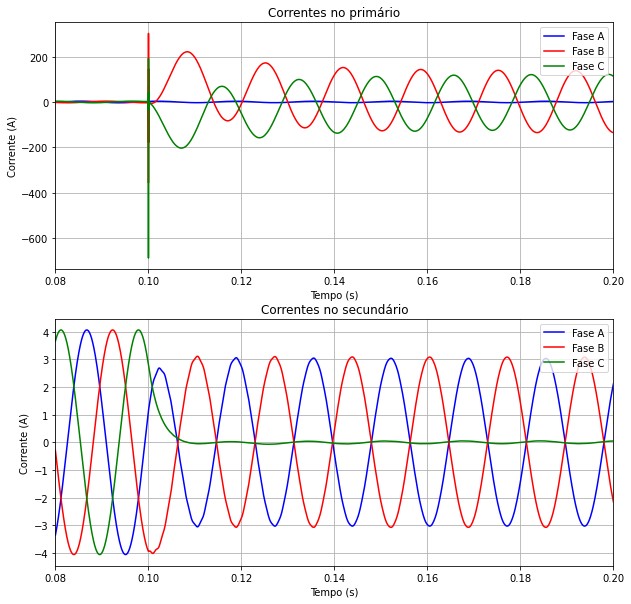

In [ ]:
t, C1, C2 = data[:,0], data[:,1:4], data[:,4:]
plotCorrentes(t,C1,C2)

Deixar as correntes do primário e secundário em fase:

In [ ]:
if theta21 != 0:
  nC = (t[-1] - t[0])/(1/60) #quantidade de ciclos nos dados
  NPC = len(t) / nC #numero de pontos por ciclo

# Ajustar amplitude dos sinais.
# Deixar em fase os dois lados do transformador.
nExcluir = int(NPC/int(360/theta21))

t = t[0:-nExcluir]
C1 = C1[0:-nExcluir,:]
C2 = C2[nExcluir:,:]
print(f'Comprimento dos vetores antes  = {(C1.shape[0] + nExcluir)}')
print(f'Comprimento dos vetores depois = {C1.shape[0]}')

Comprimento dos vetores antes  = 300001
Comprimento dos vetores depois = 298613


Deixar as correntes do primário e secundário em amplitudes equivalentes (mesma amplitude em operação normal):

In [ ]:
p = RTC2/RTC1 * 1/RT # fator multiplicativo a ser aplicado nas correntes do secundario
C2 = p * C2

Correntes após ajuste de amplitude e de fase:


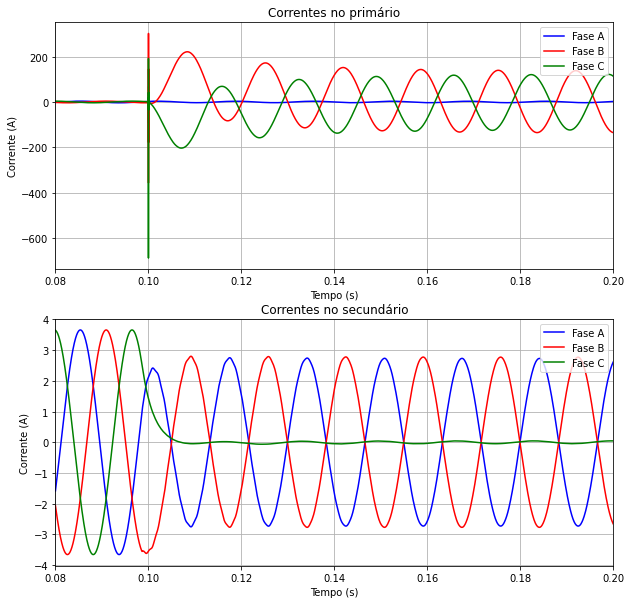

In [ ]:
print('Correntes após ajuste de amplitude e de fase:')
plotCorrentes(t,C1,C2)

Interpolação para fazer o sinal ter um número inteiro de pontos por ciclo:

In [ ]:
fsnew = float(N*f0)
tnew = np.arange(t[0],t[-1], 1/fsnew)

finterp = interp1d(t,C1, axis=0)
C1_new = finterp(tnew)
finterp = interp1d(t,C2, axis=0)
C2_new = finterp(tnew)

# plotCorrentes(tnew,C1_new,C2_new)

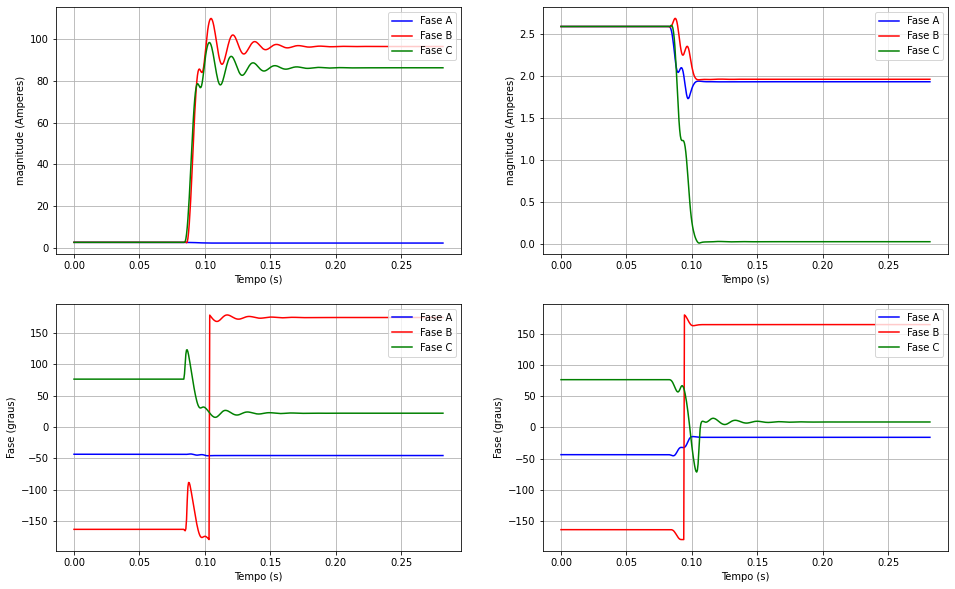

In [ ]:
[fasoresA1, time_array], [fasoresB1, _], [fasoresC1, _] = fourier_r(C1_new[:,0], N, tnew), fourier_r(C1_new[:,1], N, tnew), fourier_r(C1_new[:,2], N, tnew)
fasores1 = np.concatenate((fasoresA1.reshape(fasoresA1.shape[0], 1), fasoresB1.reshape(fasoresB1.shape[0], 1), fasoresC1.reshape(fasoresC1.shape[0], 1)), axis=1)

[fasoresA2, _], [fasoresB2, _], [fasoresC2, _] = fourier_r(C2_new[:,0], N, tnew), fourier_r(C2_new[:,1], N, tnew), fourier_r(C2_new[:,2], N, tnew)
fasores2 = np.concatenate((fasoresA2.reshape(fasoresA2.shape[0], 1), fasoresB2.reshape(fasoresB2.shape[0], 1), fasoresC2.reshape(fasoresC2.shape[0], 1)), axis=1)

plotfasores(time_array, fasores1, fasores2)

#Rotina de proteção:

In [ ]:
n = int(np.floor(t_lim * N * f0))

K1 = 0.25;
K2 = 0.40;
TRIP_K1A = []
TRIP_K1B = []
TRIP_K1C = []
TRIP_K2A = []
TRIP_K2B = []
TRIP_K2C = []
TRIP_K1 = []
TRIP_K2 = []

for i in range(len(fasoresA1)):

  IopA = abs(abs(fasoresA1[i]) - abs(fasoresA2[i]))
  IrA = (abs(fasoresA1[i]) + abs(fasoresA2[i]))/2
  IopB = abs(abs(fasoresB1[i]) - abs(fasoresB2[i]))
  IrB = (abs(fasoresB1[i]) + abs(fasoresB2[i]))/2
  IopC = abs(abs(fasoresC1[i]) - abs(fasoresC2[i]))
  IrC = (abs(fasoresC1[i]) + abs(fasoresC2[i]))/2

  TRIP_K1A.append(IopA > K1 * IrA)
  TRIP_K1B.append(IopB > K1 * IrB)
  TRIP_K1C.append(IopC > K1 * IrC)

  TRIP_K2A.append(IopA > K2 * IrA)
  TRIP_K2B.append(IopB > K2 * IrB)
  TRIP_K2C.append(IopC > K2 * IrC)
  
  if i < n:

    TRIP_K1.append(False)
    TRIP_K2.append(False)

  else:

    if TRIP_K1[i-1] == 0:
      TRIP_K1.append(all(TRIP_K1A[-n:]) or all(TRIP_K1B[-n:]) or all(TRIP_K1C[-n:]))

    else:
      TRIP_K1.append(True)

    if TRIP_K2[i-1] == 0:
      TRIP_K2.append(all(TRIP_K2A[-n:]) or all(TRIP_K2B[-n:]) or all(TRIP_K2C[-n:]))
    
    else:
      TRIP_K2.append(True)

Plotar o Trip:

Com o relé ajustado em 25%, ele atua?
True

Com o relé ajustado em 40%, ele atua?
True




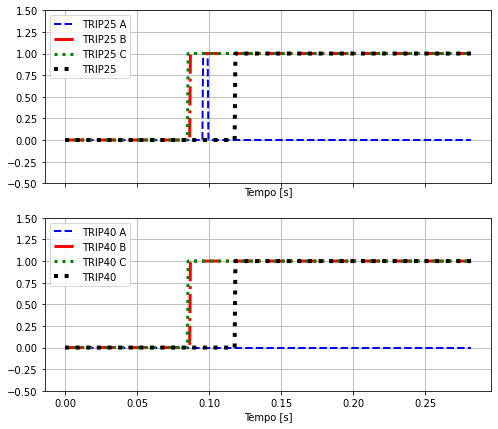

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8,7))

K1_str = str(int(K1*100))
K2_str = str(int(K2*100))

ax1.plot(time_array,TRIP_K1A, 'b--', linewidth=2, label='TRIP'+ K1_str + ' A')
ax1.plot(time_array,TRIP_K1B, 'r-.', linewidth=3,  label='TRIP'+ K1_str + ' B')
ax1.plot(time_array,TRIP_K1C, 'g:', linewidth=3,   label='TRIP'+ K1_str + ' C')
ax1.plot(time_array,TRIP_K1, 'k:', linewidth=4,   label='TRIP'+ K1_str)

ax2.plot(time_array,TRIP_K2A, 'b--', linewidth=2,  label='TRIP'+ K2_str + ' A')
ax2.plot(time_array,TRIP_K2B, 'r-.', linewidth=3,  label='TRIP'+ K2_str + ' B')
ax2.plot(time_array,TRIP_K2C, 'g:', linewidth=3,   label='TRIP'+ K2_str + ' C')
ax2.plot(time_array,TRIP_K2, 'k:', linewidth=4,   label='TRIP'+ K2_str)

ax1.legend(loc='upper left'); ax2.legend(loc='upper left')
ax1.set_ylim([-0.5,1.5]); ax2.set_ylim([-0.5,1.5])
ax1.grid(); ax2.grid()
ax1.set_xlabel('Tempo [s]'); ax2.set_xlabel('Tempo [s]');

print(f'Com o relé ajustado em {int(K1*100)}%, ele atua?')
print(any(TRIP_K1))
print(f'\nCom o relé ajustado em {int(K2*100)}%, ele atua?')
print(any(TRIP_K2))
print('\n')

Visualizar as correntes de operação e restrição:

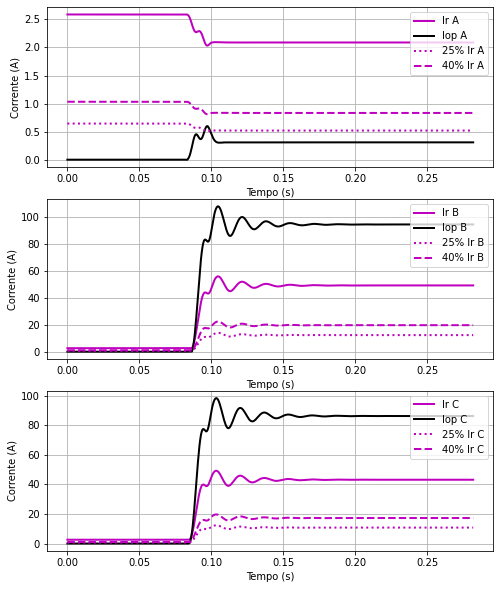

In [ ]:
newshape = (Ir(fasoresA1, fasoresA2).shape[0],1)
A = np.concatenate((Ir(fasoresA1, fasoresA2).reshape(newshape),Iop(fasoresA1, fasoresA2).reshape(newshape)), axis=1)
B = np.concatenate((Ir(fasoresB1, fasoresB2).reshape(newshape),Iop(fasoresB1, fasoresB2).reshape(newshape)), axis=1)
C = np.concatenate((Ir(fasoresC1, fasoresC2).reshape(newshape),Iop(fasoresC1, fasoresC2).reshape(newshape)), axis=1)

plotIrIop(time_array, A, B, C, [K1, K2])